In [1]:
# CNN

In [3]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float16'

In [4]:
# INIT
# PART 1
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 10001, 1000))
number_samples = [128, 256, 512, 1024, 2048, 4096] 
# number_samples = [4096, 4915, 5734, 6554, 7373, 8192]

# cnn_type = "classification"  # {"classification", "regression"}
validation_size, noise_floor = 0.2, -110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 100, 100, 8, 50  # su_size:30 for 1000, 10 for 100
cell_size = 10
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope = 'log', 5  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 20, 5
propagation_model = 'splat' # 'splat', 'log', 'testbed'
noise, std = False, 1 # False for splat
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 1600
    sensors_file_path = f"data/sensors/square{100}/{sensors_num}/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 10
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors" if sensors else f"/pus_1_sus_{number_image_channels}_channels") + "/images"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '_transfer/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (f"{intensity_degradation}_{slope}")) + (
    "/" + str(sensors_num) + "sensors" if sensors else f"/{max_pus_num}pus") + \
        f"_{max_sus_num}sus_{number_image_channels}channels" + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [5]:
image_dir

'ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/images'

In [6]:
# LOAD DATA
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 2
cols = [i for i in range(num_columns)]
dataset_name = "dynamic_pus_using_pus_70000_min10_max20PUs_min1_max5SUs_square100grid_splat_2021_10_19_17_54.txt"
max_dataset_name = "dynamic_pus_max_power_70000_min10_max20PUs_min1_max5SUs_square100grid_splat_2021_10_19_17_54.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
    set_file.write(max_dataset_name)

dataframe = pd.read_csv('data/' 
                        + dataset_name, delimiter=',', header=None, names=cols)
dataframe_max = pd.read_csv('data/' 
                            + max_dataset_name, delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)
dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
                        ignore_index=True)

idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = dataframe_tot.values
data_reg[data_reg < noise_floor] = noise_floor
# data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
#                            dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
# data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
# y_class_power = dataframe_tot.values[:, -1]

if sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe, dataframe_tot, dataframe_max

In [5]:
data_reg.shape

(44931, 79)

In [7]:
data_reg = np.concatenate((data_reg[:,:2500], np.ones((4000, 1)), data_reg[:, 2500:2504],
               data_reg[:, 2505:]), axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 19126 and the array at index 1 has size 4000

In [ ]:
data_reg[0, sensors_num:]

In [12]:
data_reg = data_reg[:30000][:]

In [ ]:
data_reg[512:1024, :] = data_reg[:512, :]

In [ ]:
data_reg[4096:8192, sensors_num:] = data_reg[:4096, sensors_num:]

In [ ]:
print(data_reg[10, :])
print(data_reg[266, :])

In [14]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5 * cell_size

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle', pu_param=None, 
                 su_shape='circle', su_param=None, intensity_degradation="log", max_pu_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1]))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2])))
                pu_p = data[pu_i * 3 + 3]
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][int(abs(pu_p))//10][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][int(abs(pu_p))//5][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][int(abs(pu_p))//5][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_param, ss_shape = pu_param, pu_shape
            for ss_i in range(sensors_num):
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x))), max(0, min(max_x-1, int(
                    sensors_location[ss_i].y))), max(noise_floor, data[ss_i])
                ss_channel = 0 
#                 if -62.5 <= ss_p < -50.0:
#                     ss_channel = 1
#                 elif -75.0 <= ss_p < -62.6:
#                     ss_channel = 2
#                 elif -87.5 <= ss_p < -75.0:
#                     ss_channel = 3
#                 elif -100.0 <= ss_p < -87.5:
#                     ss_channel = 4
# #                 elif -70.0 <= ss_p < -65.0:
# #                     ss_channel = 5
#                 elif ss_p < -100.0:
#                     ss_channel = 5
#                 if -75 <= ss_p < -65.0:
#                     ss_channel = 1
#                 elif -90.0 <= ss_p < -75:
#                     ss_channel = 2
#                 elif -90.0 <= ss_p < -80.0:
#                     ss_channel = 3
#                 elif -100.0 <= ss_p < -90.0:
#                     ss_channel = 4
#                 if ss_p < -70.0:
#                     ss_channel = 1
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            su_param_p = get_pu_param(su_shape, intensity_degradation, su_p, noise_floor, slope)
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param_p, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -2
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        pus_num = int(data[0])
#             print(pus_num)
        
#         for pu_i in range(pus_num):
#             pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
#             if pu_param is None:
#                 pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
#             else:
#                 pu_param_p = pu_param
#             points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
#             for point in points:
#                 if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
#                     if intensity_degradation == "linear":
#                         image[0][0][point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
#                                                               /(pu_p + abs(noise_floor)), 0)
#                     elif intensity_degradation == "log":
#                         if point.dist < 1:
#                             image[0][0][point.p.x][point.p.y] = 1
#                         else:
#                             image[0][0][point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
#                                                                  /(pu_p + abs(noise_floor)), 0)
#                     image[0][0][point.p.x][point.p.y] = min(image[0][0][point.p.x][point.p.y], 1.0)
        for pu_i in range(pus_num):
            pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1]))) 
            pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2])))
            pu_p = data[pu_i * 3 + 3]
            
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                            max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        else:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
#                                 max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        
        # creating SU image
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
            
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image
#         su_num = (len(data) - pus_num * 3) // 2
#         if not (len(data) - pus_num * 3) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
# #         su_image = np.zeros((max_x, max_y), dtype=float_memory_used)
#         if su_param is None:
#             # if su_param is unavailable, a circle(square) with radius(side) 1 is created
#             if su_shape == 'circle':
#                 su_param = Circle(1)
#             elif su_shape == 'square':
#                 su_param = Square(1)
#             elif su_shape == 'point':
#                 su_param = None
#             else:
#                 raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
#         su_intensity = 1.
#         for su_i in range(su_num):
#             su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) +su_i*2]))
#                                   ), max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) + su_i*2+1]))), su_intensity
#             points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
#             for point in points:
#                 if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
#                     if number_image_channels > 1:
#                         image[0][1][point.p.x][point.p.y] = su_intensity
#                     elif number_image_channels == 1:
#                         image[0][0][point.p.x][point.p.y] = su_intensity
# #         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
# #         return np.append(pu_image, su_image, axis=0)
#         return image
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-int(r/cell_size), -max_x), 
                             min(int(r/cell_size), max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num):
    if False and style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        suffix = 'npz'  # npy, npz
        image = np.load(image_dir + '/image' + str(image_num) + '.' + suffix)  
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

In [ ]:
plt.hist(data_reg[:,0:1:sensors_num], bins='auto')

In [15]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -50)
        if False and style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
    #         np.save(image_dir + '/image' + str(image_num), image)
            np.savez_compressed(image_dir + '/image' + str(image_num), a=image)
        del image
        

In [27]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|███████████████████████████████████████| 3000/3000 [05:25<00:00,  9.21it/s]


In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point)

In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point,"close") if math.sqrt((point.x-917)**2+(point.y-415)**2)<=1.5 else None

In [ ]:
count = [0, 0, 0, 0]
idxx = [[],[],[],[]]
for i in range(data_reg.shape[0]):
    pus_c = int(data_reg[i][0]) * 3 + 1
    idx = int(data_reg[i][pus_c]) - 1
    count[idx] += 1
    idxx[idx].append(i)

In [ ]:
print(count)
print(idxx[3])

In [17]:
imm = read_image(0)

In [ ]:
imm[300].shape

In [ ]:
data_reg[:,-1].shape

In [19]:
data_reg[0,:]

array([ 10.   ,   3.   ,  67.   , -25.176,  61.   ,  78.   , -21.186,
        63.   ,  49.   , -28.75 ,  78.   ,  46.   ,  -7.82 ,  11.   ,
        91.   ,  -6.503,  75.   ,  84.   , -27.874,  26.   ,  12.   ,
        -6.862,  93.   ,  75.   , -24.521,  14.   ,  39.   , -21.42 ,
        41.   ,  98.   , -13.011,   5.   ,  34.   ,  56.   ,   9.935,
        46.   ,  92.   , -33.46 ,  80.   ,  32.   , -41.9  ,   1.   ,
        92.   , -14.34 ,   5.   ,  25.   ,  52.067,   0.   ,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan, -27.35 ])

<AxesSubplot:>

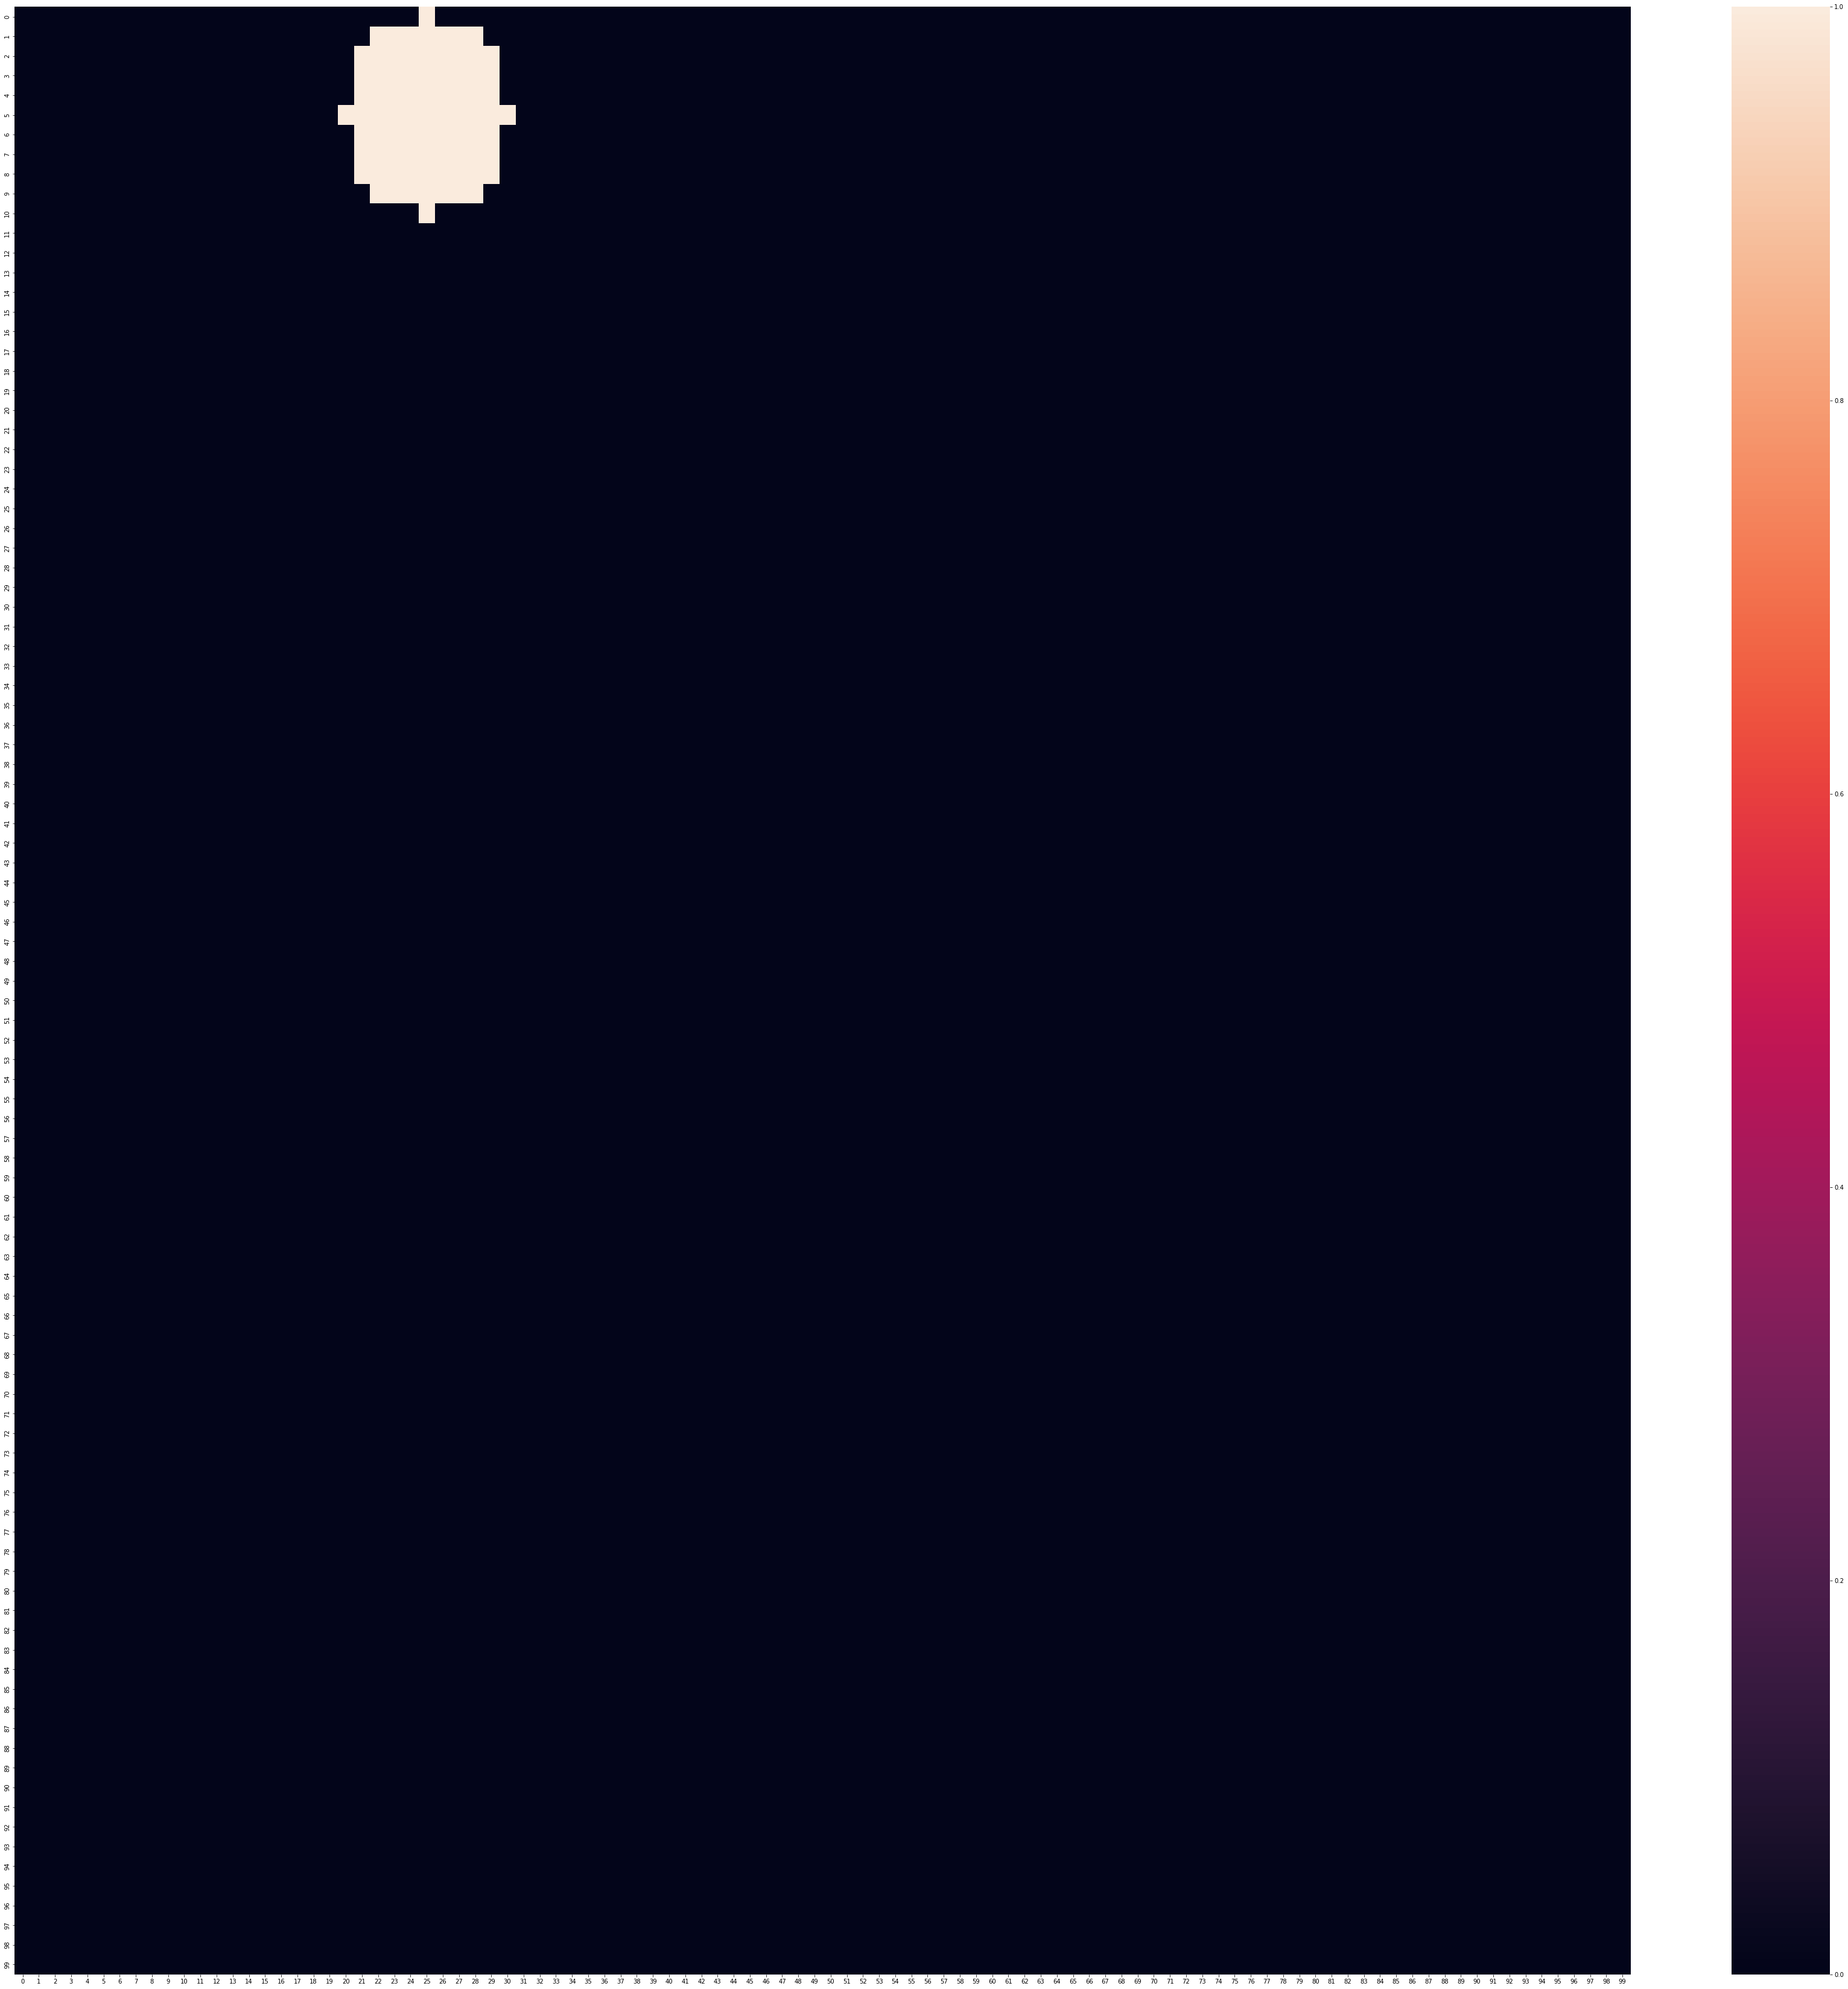

In [26]:
fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(imm[0][7], ax=ax)

In [28]:
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"  # lecun_normal
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
    cnn.add(layers.Dropout(0.15))
    
    cnn.add(layers.Conv2D(1*num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
    cnn.add(layers.Dropout(0.15))
    
    cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
    cnn.add(layers.Dropout(0.15))
    
    cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
    cnn.add(layers.Dropout(0.15))
# from here for 1000
    if max(max_x, max_y) == 1000:
        cnn.add(layers.Conv2D(1*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))
#     cnn = layers.GlobalAveragePooling2D()(cnn)
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn.add(BatchNormalization())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn.add(BatchNormalization())
#     cnn.add(layers.Dropout(0.25))
    cnn.add(layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init))
    return cnn


class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, conserve=0):
#         print(dataset.shape[0])
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.number_image_channels, self.max_x, self.max_y), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)
         

In [29]:
cnn = cnn_model(10, 0, 0)

2021-10-29 15:26:00.297216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 15:26:00.301192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 15:26:00.301666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 15:26:00.302471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 100, 100)      730       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 50, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 50, 50)        40        
_________________________________________________________________
dropout (Dropout)            (None, 10, 50, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 50, 50)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 25, 25)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 25, 25)        4

In [31]:
tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2021-10-29 15:26:07.309153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 15:26:07.309440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 15:26:07.309621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 15:26:07.309800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 15:26:07.309947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [34]:
number_samples  # [128, 256, 512, 1024, 2048, 4096, 8192]

[2048, 4096]

In [35]:
# CNN: support batching
TEST, CONSERVE = True, False
mini_batch = 16 if max(max_x, max_y) == 1000 else 32
epochs = 35 if max(max_x, max_y) == 1000 else 100
MAX_QUEUE_SIZE, WORKERS = 28, 4
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0, 0.1, 1, 10]  #0.001, 0.01, 0.1, 
# lambda_vec = [0.01, 0.1, 1]
# lambda_vec = [10]
# MODEL_PATH = 'models/'
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
#     if num_sample_idx < 3:
#         continue
#     if num_sample_idx == 0:
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer='adam', 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
#     if num_sample_idx == 3:    
#         models_min_mae = [8.27781, 8.23545, 8.20838, 7.74743]
#         models_min_mae += [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(4,lamb_idx+1)]
#     else:
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 2048 , New samples: 2048
Validation size: 410 , starts: 2048 , ends: 2457
Epoch 1/100


/tmp/ipykernel_2759206/4170749990.py:114: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
2021-10-29 15:26:45.863657: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-29 15:26:47.354578: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-10-29 15:26:48.287483: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multipli

64/64 - 4s - loss: 842.1705 - mse: 842.1705 - mae: 25.8287 - fp_mae: 24.2336 - val_loss: 881.5425 - val_mse: 881.5425 - val_mae: 26.0413 - val_fp_mae: 24.7395

Epoch 00001: val_mae improved from inf to 26.04132, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_0.h5
Epoch 2/100
64/64 - 1s - loss: 786.7859 - mse: 786.7859 - mae: 24.7264 - fp_mae: 23.5341 - val_loss: 685.3392 - val_mse: 685.3392 - val_mae: 22.8524 - val_fp_mae: 21.2095

Epoch 00002: val_mae improved from 26.04132 to 22.85244, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_0.h5
Epoch 3/100
64/64 - 1s - loss: 707.9209 - mse: 707.9209 - mae: 23.2817 - fp_mae: 22.5081 - val_loss: 565.3997 - val_mse: 565.3997 - val_mae: 20.9766 - val_fp_mae: 17.8785

Epoch 00003: val_mae improved from 22.85244 to 

64/64 - 1s - loss: 45.0307 - mse: 45.0307 - mae: 5.3162 - fp_mae: 2.5775 - val_loss: 114.4483 - val_mse: 114.4483 - val_mae: 8.2942 - val_fp_mae: 4.6063

Epoch 00028: val_mae did not improve from 8.13962
Epoch 29/100
64/64 - 1s - loss: 41.6132 - mse: 41.6132 - mae: 5.1143 - fp_mae: 2.5412 - val_loss: 121.1524 - val_mse: 121.1524 - val_mae: 8.4252 - val_fp_mae: 5.2791

Epoch 00029: val_mae did not improve from 8.13962
Epoch 30/100
64/64 - 1s - loss: 42.6125 - mse: 42.6125 - mae: 5.1671 - fp_mae: 2.6255 - val_loss: 117.5753 - val_mse: 117.5753 - val_mae: 8.4246 - val_fp_mae: 5.1465

Epoch 00030: val_mae did not improve from 8.13962
Epoch 31/100
64/64 - 1s - loss: 41.0810 - mse: 41.0810 - mae: 5.0522 - fp_mae: 2.4687 - val_loss: 124.0816 - val_mse: 124.0816 - val_mae: 8.6585 - val_fp_mae: 5.1553

Epoch 00031: val_mae did not improve from 8.13962
Epoch 32/100
64/64 - 1s - loss: 40.7350 - mse: 40.7350 - mae: 5.0171 - fp_mae: 2.4957 - val_loss: 124.9510 - val_mse: 124.9510 - val_mae: 8.6531 

64/64 - 1s - loss: 29.4016 - mse: 29.4016 - mae: 4.2398 - fp_mae: 2.0623 - val_loss: 126.7001 - val_mse: 126.7001 - val_mae: 8.6148 - val_fp_mae: 5.4361

Epoch 00066: val_mae did not improve from 8.13962
Epoch 67/100
64/64 - 1s - loss: 29.7646 - mse: 29.7646 - mae: 4.3016 - fp_mae: 2.1817 - val_loss: 130.7030 - val_mse: 130.7030 - val_mae: 8.7331 - val_fp_mae: 6.0170

Epoch 00067: val_mae did not improve from 8.13962
Epoch 68/100
64/64 - 1s - loss: 30.0536 - mse: 30.0536 - mae: 4.3089 - fp_mae: 2.2232 - val_loss: 130.7557 - val_mse: 130.7557 - val_mae: 8.8524 - val_fp_mae: 4.2438

Epoch 00068: val_mae did not improve from 8.13962
Epoch 69/100
64/64 - 1s - loss: 28.6588 - mse: 28.6588 - mae: 4.2519 - fp_mae: 2.0990 - val_loss: 122.9196 - val_mse: 122.9196 - val_mae: 8.4419 - val_fp_mae: 4.8720

Epoch 00069: val_mae did not improve from 8.13962
Epoch 70/100
64/64 - 1s - loss: 28.0235 - mse: 28.0235 - mae: 4.1767 - fp_mae: 2.0843 - val_loss: 126.1890 - val_mse: 126.1890 - val_mae: 8.6369 

64/64 - 2s - loss: 852.5021 - mse: 841.7341 - mae: 25.8310 - fp_mae: 24.2328 - val_loss: 886.2859 - val_mse: 875.7556 - val_mae: 25.8692 - val_fp_mae: 24.6708

Epoch 00001: val_mae improved from inf to 25.86921, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_1.h5
Epoch 2/100
64/64 - 1s - loss: 791.2607 - mse: 780.9636 - mae: 24.6074 - fp_mae: 23.4676 - val_loss: 710.1658 - val_mse: 700.0570 - val_mae: 23.0537 - val_fp_mae: 21.5448

Epoch 00002: val_mae improved from 25.86921 to 23.05370, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_1.h5
Epoch 3/100
64/64 - 1s - loss: 710.5831 - mse: 700.5363 - mae: 23.0954 - fp_mae: 22.3986 - val_loss: 571.4041 - val_mse: 561.3815 - val_mae: 20.6801 - val_fp_mae: 18.2256

Epoch 00003: val_mae improved from 23.05370 to 

64/64 - 1s - loss: 62.1467 - mse: 47.9356 - mae: 5.5267 - fp_mae: 2.7590 - val_loss: 142.5261 - val_mse: 128.2885 - val_mae: 9.0037 - val_fp_mae: 3.8303

Epoch 00028: val_mae did not improve from 8.51432
Epoch 29/100
64/64 - 1s - loss: 58.7965 - mse: 44.5466 - mae: 5.2976 - fp_mae: 2.6418 - val_loss: 143.1472 - val_mse: 128.8831 - val_mae: 9.1454 - val_fp_mae: 2.9839

Epoch 00029: val_mae did not improve from 8.51432
Epoch 30/100
64/64 - 1s - loss: 58.8847 - mse: 44.6105 - mae: 5.3274 - fp_mae: 2.6590 - val_loss: 130.0723 - val_mse: 115.7898 - val_mae: 8.6144 - val_fp_mae: 3.8916

Epoch 00030: val_mae did not improve from 8.51432
Epoch 31/100
64/64 - 1s - loss: 59.0155 - mse: 44.7157 - mae: 5.3258 - fp_mae: 2.7201 - val_loss: 185.7184 - val_mse: 171.3912 - val_mae: 10.3937 - val_fp_mae: 2.7376

Epoch 00031: val_mae did not improve from 8.51432
Epoch 32/100
64/64 - 2s - loss: 58.5717 - mse: 44.2291 - mae: 5.2764 - fp_mae: 2.6372 - val_loss: 133.6105 - val_mse: 119.2408 - val_mae: 8.6901

64/64 - 1s - loss: 44.3550 - mse: 30.3679 - mae: 4.3475 - fp_mae: 2.2054 - val_loss: 136.6508 - val_mse: 122.6766 - val_mae: 8.8163 - val_fp_mae: 3.8172

Epoch 00066: val_mae did not improve from 8.51432
Epoch 67/100
64/64 - 1s - loss: 43.9206 - mse: 29.9640 - mae: 4.3368 - fp_mae: 2.1709 - val_loss: 133.4436 - val_mse: 119.4925 - val_mae: 8.6738 - val_fp_mae: 4.4875

Epoch 00067: val_mae did not improve from 8.51432
Epoch 68/100
64/64 - 1s - loss: 44.1794 - mse: 30.2700 - mae: 4.3282 - fp_mae: 2.1901 - val_loss: 139.1039 - val_mse: 125.2161 - val_mae: 8.8822 - val_fp_mae: 5.4497

Epoch 00068: val_mae did not improve from 8.51432
Epoch 69/100
64/64 - 1s - loss: 44.1472 - mse: 30.2578 - mae: 4.2951 - fp_mae: 2.0965 - val_loss: 140.2414 - val_mse: 126.3719 - val_mae: 8.9433 - val_fp_mae: 4.7140

Epoch 00069: val_mae did not improve from 8.51432
Epoch 70/100
64/64 - 1s - loss: 44.1819 - mse: 30.3489 - mae: 4.3058 - fp_mae: 2.2039 - val_loss: 135.3736 - val_mse: 121.5583 - val_mae: 8.7392 

64/64 - 2s - loss: 927.2966 - mse: 843.2924 - mae: 25.8646 - fp_mae: 24.2511 - val_loss: 1095.3969 - val_mse: 1031.9615 - val_mae: 28.2783 - val_fp_mae: 27.1903

Epoch 00001: val_mae improved from inf to 28.27831, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_2.h5
Epoch 2/100
64/64 - 1s - loss: 836.2665 - mse: 785.2027 - mae: 24.6821 - fp_mae: 23.5038 - val_loss: 1038.3699 - val_mse: 996.4734 - val_mae: 27.6552 - val_fp_mae: 26.7726

Epoch 00002: val_mae improved from 28.27831 to 27.65522, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_2.h5
Epoch 3/100
64/64 - 2s - loss: 740.2145 - mse: 702.7939 - mae: 23.1787 - fp_mae: 22.4355 - val_loss: 724.5031 - val_mse: 691.0116 - val_mae: 22.7842 - val_fp_mae: 21.4124

Epoch 00003: val_mae improved from 27.65522 


Epoch 00029: val_mae did not improve from 8.19112
Epoch 30/100
64/64 - 1s - loss: 102.0862 - mse: 60.6219 - mae: 6.1751 - fp_mae: 3.3001 - val_loss: 211.7991 - val_mse: 170.4330 - val_mae: 10.1486 - val_fp_mae: 4.5041

Epoch 00030: val_mae did not improve from 8.19112
Epoch 31/100
64/64 - 1s - loss: 99.3577 - mse: 58.1753 - mae: 5.9743 - fp_mae: 3.1979 - val_loss: 167.0926 - val_mse: 125.8756 - val_mae: 8.6373 - val_fp_mae: 4.8023

Epoch 00031: val_mae did not improve from 8.19112
Epoch 32/100
64/64 - 1s - loss: 98.4066 - mse: 57.2305 - mae: 5.9821 - fp_mae: 3.1821 - val_loss: 180.8713 - val_mse: 139.6178 - val_mae: 9.1553 - val_fp_mae: 4.1710

Epoch 00032: val_mae did not improve from 8.19112
Epoch 33/100
64/64 - 1s - loss: 96.9165 - mse: 55.6785 - mae: 5.9117 - fp_mae: 3.1082 - val_loss: 210.2741 - val_mse: 169.1038 - val_mae: 9.8164 - val_fp_mae: 6.4436

Epoch 00033: val_mae did not improve from 8.19112
Epoch 34/100
64/64 - 1s - loss: 98.1976 - mse: 57.0719 - mae: 5.9673 - fp_mae: 


Epoch 00067: val_mae did not improve from 8.19112
Epoch 68/100
64/64 - 1s - loss: 77.0794 - mse: 41.2867 - mae: 5.1092 - fp_mae: 2.6713 - val_loss: 171.3794 - val_mse: 135.7800 - val_mae: 9.0680 - val_fp_mae: 5.1162

Epoch 00068: val_mae did not improve from 8.19112
Epoch 69/100
64/64 - 1s - loss: 78.4331 - mse: 42.9252 - mae: 5.1728 - fp_mae: 2.6848 - val_loss: 176.2038 - val_mse: 140.8073 - val_mae: 9.1961 - val_fp_mae: 4.9860

Epoch 00069: val_mae did not improve from 8.19112
Epoch 70/100
64/64 - 1s - loss: 77.9965 - mse: 42.5888 - mae: 5.1569 - fp_mae: 2.7143 - val_loss: 180.5098 - val_mse: 145.2501 - val_mae: 9.2310 - val_fp_mae: 6.4179

Epoch 00070: val_mae did not improve from 8.19112
Epoch 71/100
64/64 - 1s - loss: 77.7119 - mse: 42.3702 - mae: 5.1415 - fp_mae: 2.7368 - val_loss: 181.3009 - val_mse: 146.0421 - val_mae: 9.2865 - val_fp_mae: 6.4641

Epoch 00071: val_mae did not improve from 8.19112
Epoch 72/100
64/64 - 1s - loss: 76.3224 - mse: 41.1374 - mae: 5.0581 - fp_mae: 2.

64/64 - 2s - loss: 1492.8613 - mse: 844.5601 - mae: 25.8718 - fp_mae: 24.2563 - val_loss: 1289.4030 - val_mse: 927.7659 - val_mae: 26.8738 - val_fp_mae: 25.4197

Epoch 00001: val_mae improved from inf to 26.87376, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_3.h5
Epoch 2/100
64/64 - 1s - loss: 1050.9506 - mse: 799.1761 - mae: 24.9316 - fp_mae: 23.6433 - val_loss: 1105.0962 - val_mse: 930.7974 - val_mae: 26.9024 - val_fp_mae: 25.4855

Epoch 00002: val_mae did not improve from 26.87376
Epoch 3/100
64/64 - 1s - loss: 862.9659 - mse: 726.3430 - mae: 23.5317 - fp_mae: 22.6540 - val_loss: 996.6366 - val_mse: 887.0074 - val_mae: 26.2167 - val_fp_mae: 24.7793

Epoch 00003: val_mae improved from 26.87376 to 26.21667, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lamb


Epoch 00027: val_mae did not improve from 9.23504
Epoch 28/100
64/64 - 1s - loss: 224.3574 - mse: 140.3532 - mae: 9.0187 - fp_mae: 6.2078 - val_loss: 293.3761 - val_mse: 210.8184 - val_mae: 11.3594 - val_fp_mae: 5.5182

Epoch 00028: val_mae did not improve from 9.23504
Epoch 29/100
64/64 - 1s - loss: 222.1231 - mse: 139.3528 - mae: 8.9889 - fp_mae: 6.1249 - val_loss: 219.3382 - val_mse: 134.6116 - val_mae: 8.7097 - val_fp_mae: 6.0647

Epoch 00029: val_mae improved from 9.23504 to 8.70972, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/2048/best_model_lambda_3.h5
Epoch 30/100
64/64 - 1s - loss: 220.7383 - mse: 137.6474 - mae: 8.9675 - fp_mae: 6.0418 - val_loss: 231.1714 - val_mse: 149.7855 - val_mae: 9.2898 - val_fp_mae: 7.0115

Epoch 00030: val_mae did not improve from 8.70972
Epoch 31/100
64/64 - 1s - loss: 219.4445 - mse: 139.5948 - mae: 8.9767 - fp_mae: 6.0015 - val_loss: 496.0793 - val_m


Epoch 00062: val_mae did not improve from 8.66386
Epoch 63/100
64/64 - 1s - loss: 176.7268 - mse: 128.8526 - mae: 8.7691 - fp_mae: 5.1024 - val_loss: 217.0265 - val_mse: 169.6628 - val_mae: 10.2239 - val_fp_mae: 7.6173

Epoch 00063: val_mae did not improve from 8.66386
Epoch 64/100
64/64 - 1s - loss: 175.6657 - mse: 128.7264 - mae: 8.7882 - fp_mae: 5.1139 - val_loss: 215.1580 - val_mse: 168.9214 - val_mae: 10.1998 - val_fp_mae: 5.3888

Epoch 00064: val_mae did not improve from 8.66386
Epoch 65/100
64/64 - 1s - loss: 175.7562 - mse: 129.1747 - mae: 8.7988 - fp_mae: 5.0686 - val_loss: 214.5909 - val_mse: 167.3025 - val_mae: 10.1448 - val_fp_mae: 5.1345

Epoch 00065: val_mae did not improve from 8.66386
Epoch 66/100
64/64 - 1s - loss: 175.8653 - mse: 127.9610 - mae: 8.7652 - fp_mae: 4.9978 - val_loss: 230.6227 - val_mse: 183.5849 - val_mae: 10.6318 - val_fp_mae: 8.3579

Epoch 00066: val_mae did not improve from 8.66386
Epoch 67/100
64/64 - 1s - loss: 172.9792 - mse: 126.8484 - mae: 8.755


Epoch 00099: val_mae did not improve from 8.61472
Epoch 100/100
64/64 - 1s - loss: 161.1213 - mse: 126.3449 - mae: 8.7041 - fp_mae: 4.8107 - val_loss: 195.3804 - val_mse: 160.7701 - val_mae: 9.7692 - val_fp_mae: 7.6193

Epoch 00100: val_mae did not improve from 8.61472

Lambda: 10 , Time: 0:02:23
Train Error(all epochs): 8.688057899475098 
 [25.872, 24.932, 23.532, 21.945, 20.363, 18.882, 17.468, 16.173, 15.055, 14.004, 12.999, 12.095, 11.411, 10.789, 10.331, 9.923, 9.677, 9.472, 9.359, 9.343, 9.238, 9.17, 9.153, 9.079, 9.107, 9.006, 9.039, 9.019, 8.989, 8.967, 8.977, 8.98, 9.051, 9.162, 8.943, 8.924, 8.927, 8.943, 8.87, 8.943, 8.862, 8.872, 8.818, 8.902, 8.802, 8.827, 8.82, 8.832, 8.813, 8.816, 8.796, 8.774, 8.807, 8.772, 8.738, 8.815, 8.767, 8.787, 8.753, 8.773, 8.773, 8.768, 8.769, 8.788, 8.799, 8.765, 8.755, 8.739, 8.775, 8.806, 8.76, 8.718, 8.754, 8.736, 8.725, 8.787, 8.737, 8.734, 8.728, 8.725, 8.748, 8.764, 8.756, 8.688, 8.725, 8.8, 8.736, 8.732, 8.731, 8.718, 8.745, 8.706, 8.7


Epoch 00013: val_mae did not improve from 7.86836
Epoch 14/100
128/128 - 3s - loss: 75.6697 - mse: 75.6697 - mae: 6.8561 - fp_mae: 3.4001 - val_loss: 103.6240 - val_mse: 103.6240 - val_mae: 7.9825 - val_fp_mae: 4.1899

Epoch 00014: val_mae did not improve from 7.86836
Epoch 15/100
128/128 - 3s - loss: 73.7442 - mse: 73.7442 - mae: 6.8393 - fp_mae: 3.3899 - val_loss: 109.8678 - val_mse: 109.8678 - val_mae: 8.2269 - val_fp_mae: 3.3488

Epoch 00015: val_mae did not improve from 7.86836
Epoch 16/100
128/128 - 3s - loss: 71.6296 - mse: 71.6296 - mae: 6.7058 - fp_mae: 3.3671 - val_loss: 102.0470 - val_mse: 102.0470 - val_mae: 7.9628 - val_fp_mae: 3.6388

Epoch 00016: val_mae did not improve from 7.86836
Epoch 17/100
128/128 - 3s - loss: 68.5956 - mse: 68.5956 - mae: 6.5074 - fp_mae: 3.2345 - val_loss: 106.7535 - val_mse: 106.7535 - val_mae: 8.0672 - val_fp_mae: 4.3771

Epoch 00017: val_mae did not improve from 7.86836
Epoch 18/100
128/128 - 3s - loss: 68.8553 - mse: 68.8553 - mae: 6.5348 - 


Epoch 00051: val_mae did not improve from 7.86836
Epoch 52/100
128/128 - 3s - loss: 38.5794 - mse: 38.5794 - mae: 4.9476 - fp_mae: 2.4726 - val_loss: 120.3474 - val_mse: 120.3474 - val_mae: 8.5182 - val_fp_mae: 4.2998

Epoch 00052: val_mae did not improve from 7.86836
Epoch 53/100
128/128 - 3s - loss: 38.1763 - mse: 38.1763 - mae: 4.8986 - fp_mae: 2.4200 - val_loss: 125.2292 - val_mse: 125.2292 - val_mae: 8.6524 - val_fp_mae: 4.2488

Epoch 00053: val_mae did not improve from 7.86836
Epoch 54/100
128/128 - 3s - loss: 38.0093 - mse: 38.0093 - mae: 4.9010 - fp_mae: 2.4937 - val_loss: 123.3334 - val_mse: 123.3334 - val_mae: 8.6079 - val_fp_mae: 4.8392

Epoch 00054: val_mae did not improve from 7.86836
Epoch 55/100
128/128 - 3s - loss: 36.9612 - mse: 36.9612 - mae: 4.8032 - fp_mae: 2.3961 - val_loss: 123.7700 - val_mse: 123.7700 - val_mae: 8.6218 - val_fp_mae: 5.0856

Epoch 00055: val_mae did not improve from 7.86836
Epoch 56/100
128/128 - 3s - loss: 36.6730 - mse: 36.6730 - mae: 4.8106 - 


Epoch 00089: val_mae did not improve from 7.86836
Epoch 90/100
128/128 - 3s - loss: 29.8666 - mse: 29.8666 - mae: 4.2772 - fp_mae: 2.2045 - val_loss: 128.1565 - val_mse: 128.1565 - val_mae: 8.8572 - val_fp_mae: 4.8117

Epoch 00090: val_mae did not improve from 7.86836
Epoch 91/100
128/128 - 3s - loss: 30.5733 - mse: 30.5733 - mae: 4.3754 - fp_mae: 2.2097 - val_loss: 125.6034 - val_mse: 125.6034 - val_mae: 8.7172 - val_fp_mae: 4.6291

Epoch 00091: val_mae did not improve from 7.86836
Epoch 92/100
128/128 - 3s - loss: 30.5518 - mse: 30.5518 - mae: 4.3950 - fp_mae: 2.1718 - val_loss: 129.8255 - val_mse: 129.8255 - val_mae: 8.8349 - val_fp_mae: 4.7532

Epoch 00092: val_mae did not improve from 7.86836
Epoch 93/100
128/128 - 3s - loss: 30.6159 - mse: 30.6159 - mae: 4.3573 - fp_mae: 2.1824 - val_loss: 128.6854 - val_mse: 128.6854 - val_mae: 8.8163 - val_fp_mae: 4.2746

Epoch 00093: val_mae did not improve from 7.86836
Epoch 94/100
128/128 - 3s - loss: 29.6041 - mse: 29.6041 - mae: 4.2779 - 


Epoch 00008: val_mae did not improve from 11.14014
Epoch 9/100
128/128 - 3s - loss: 109.6442 - mse: 98.7158 - mae: 7.7836 - fp_mae: 4.8340 - val_loss: 131.2450 - val_mse: 120.1389 - val_mae: 8.6457 - val_fp_mae: 6.3359

Epoch 00009: val_mae improved from 11.14014 to 8.64571, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/4096/best_model_lambda_1.h5
Epoch 10/100
128/128 - 3s - loss: 103.2853 - mse: 92.0403 - mae: 7.5332 - fp_mae: 4.1989 - val_loss: 121.6913 - val_mse: 110.3098 - val_mae: 8.3794 - val_fp_mae: 5.4352

Epoch 00010: val_mae improved from 8.64571 to 8.37940, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/4096/best_model_lambda_1.h5
Epoch 11/100
128/128 - 3s - loss: 97.8986 - mse: 86.4549 - mae: 7.3467 - fp_mae: 3.8925 - val_loss: 119.6290 - val_mse: 108.0649 - val_mae: 8.2580 - val_fp_ma


Epoch 00042: val_mae did not improve from 8.10321
Epoch 43/100
128/128 - 3s - loss: 56.8595 - mse: 42.0330 - mae: 5.1080 - fp_mae: 2.5314 - val_loss: 129.9163 - val_mse: 115.0989 - val_mae: 8.5097 - val_fp_mae: 4.5549

Epoch 00043: val_mae did not improve from 8.10321
Epoch 44/100
128/128 - 3s - loss: 55.6316 - mse: 40.8148 - mae: 5.0718 - fp_mae: 2.5876 - val_loss: 133.7121 - val_mse: 118.8668 - val_mae: 8.4847 - val_fp_mae: 4.8640

Epoch 00044: val_mae did not improve from 8.10321
Epoch 45/100
128/128 - 3s - loss: 57.3555 - mse: 42.4857 - mae: 5.1424 - fp_mae: 2.5313 - val_loss: 135.1465 - val_mse: 120.2693 - val_mae: 8.6342 - val_fp_mae: 4.1155

Epoch 00045: val_mae did not improve from 8.10321
Epoch 46/100
128/128 - 3s - loss: 56.3181 - mse: 41.4387 - mae: 5.0846 - fp_mae: 2.5723 - val_loss: 141.6677 - val_mse: 126.7706 - val_mae: 8.9175 - val_fp_mae: 4.2252

Epoch 00046: val_mae did not improve from 8.10321
Epoch 47/100
128/128 - 3s - loss: 56.3356 - mse: 41.4022 - mae: 5.0886 - 


Epoch 00080: val_mae did not improve from 8.10321
Epoch 81/100
128/128 - 3s - loss: 49.6583 - mse: 34.9055 - mae: 4.6411 - fp_mae: 2.3013 - val_loss: 137.7462 - val_mse: 122.9888 - val_mae: 8.7787 - val_fp_mae: 4.5331

Epoch 00081: val_mae did not improve from 8.10321
Epoch 82/100
128/128 - 3s - loss: 49.3888 - mse: 34.6267 - mae: 4.6411 - fp_mae: 2.3451 - val_loss: 140.1094 - val_mse: 125.3258 - val_mae: 8.8084 - val_fp_mae: 4.1580

Epoch 00082: val_mae did not improve from 8.10321
Epoch 83/100
128/128 - 3s - loss: 49.2156 - mse: 34.4598 - mae: 4.6685 - fp_mae: 2.3125 - val_loss: 137.5227 - val_mse: 122.7521 - val_mae: 8.7734 - val_fp_mae: 4.6923

Epoch 00083: val_mae did not improve from 8.10321
Epoch 84/100
128/128 - 3s - loss: 49.2741 - mse: 34.4956 - mae: 4.6029 - fp_mae: 2.2936 - val_loss: 143.4113 - val_mse: 128.6158 - val_mae: 8.9848 - val_fp_mae: 4.7542

Epoch 00084: val_mae did not improve from 8.10321
Epoch 85/100
128/128 - 3s - loss: 49.0000 - mse: 34.2278 - mae: 4.6347 - 

128/128 - 3s - loss: 526.7018 - mse: 503.4430 - mae: 19.2938 - fp_mae: 19.0690 - val_loss: 446.3383 - val_mse: 423.7961 - val_mae: 16.8386 - val_fp_mae: 16.3906

Epoch 00003: val_mae improved from 24.67273 to 16.83858, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/4096/best_model_lambda_2.h5
Epoch 4/100
128/128 - 3s - loss: 402.3650 - mse: 380.4041 - mae: 16.3178 - fp_mae: 16.1340 - val_loss: 344.8375 - val_mse: 323.0268 - val_mae: 14.3461 - val_fp_mae: 12.3121

Epoch 00004: val_mae improved from 16.83858 to 14.34606, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/4096/best_model_lambda_2.h5
Epoch 5/100
128/128 - 3s - loss: 310.8454 - mse: 288.5320 - mae: 13.6650 - fp_mae: 13.2200 - val_loss: 276.5050 - val_mse: 253.9327 - val_mae: 12.3911 - val_fp_mae: 11.6900

Epoch 00005: val_mae improved from 1


Epoch 00032: val_mae did not improve from 7.98259
Epoch 33/100
128/128 - 3s - loss: 112.8104 - mse: 80.9878 - mae: 7.1308 - fp_mae: 3.7652 - val_loss: 249.7331 - val_mse: 217.3253 - val_mae: 11.4378 - val_fp_mae: 9.2560

Epoch 00033: val_mae did not improve from 7.98259
Epoch 34/100
128/128 - 3s - loss: 111.7990 - mse: 79.7006 - mae: 7.0288 - fp_mae: 3.6424 - val_loss: 155.9419 - val_mse: 123.6673 - val_mae: 8.7758 - val_fp_mae: 6.4264

Epoch 00034: val_mae did not improve from 7.98259
Epoch 35/100
128/128 - 3s - loss: 110.8719 - mse: 78.6354 - mae: 6.9936 - fp_mae: 3.5675 - val_loss: 137.9874 - val_mse: 105.9331 - val_mae: 8.2171 - val_fp_mae: 4.2188

Epoch 00035: val_mae did not improve from 7.98259
Epoch 36/100
128/128 - 3s - loss: 109.0513 - mse: 77.0380 - mae: 6.9421 - fp_mae: 3.6196 - val_loss: 148.7013 - val_mse: 116.6757 - val_mae: 8.4591 - val_fp_mae: 4.8561

Epoch 00036: val_mae did not improve from 7.98259
Epoch 37/100
128/128 - 3s - loss: 108.4610 - mse: 76.4732 - mae: 6.9

128/128 - 3s - loss: 95.2643 - mse: 62.0726 - mae: 6.2343 - fp_mae: 3.2433 - val_loss: 162.3253 - val_mse: 128.8402 - val_mae: 8.9348 - val_fp_mae: 6.2493

Epoch 00070: val_mae did not improve from 7.98259
Epoch 71/100
128/128 - 3s - loss: 94.9967 - mse: 61.6224 - mae: 6.2105 - fp_mae: 3.2074 - val_loss: 154.2980 - val_mse: 120.9495 - val_mae: 8.6255 - val_fp_mae: 5.7975

Epoch 00071: val_mae did not improve from 7.98259
Epoch 72/100
128/128 - 3s - loss: 94.0722 - mse: 60.8478 - mae: 6.1366 - fp_mae: 3.0877 - val_loss: 160.5562 - val_mse: 127.4892 - val_mae: 8.8158 - val_fp_mae: 6.2519

Epoch 00072: val_mae did not improve from 7.98259
Epoch 73/100
128/128 - 3s - loss: 92.6673 - mse: 59.7590 - mae: 6.0718 - fp_mae: 3.1379 - val_loss: 353.3578 - val_mse: 320.1889 - val_mae: 13.6890 - val_fp_mae: 2.0328

Epoch 00073: val_mae did not improve from 7.98259
Epoch 74/100
128/128 - 3s - loss: 94.6684 - mse: 61.5585 - mae: 6.1767 - fp_mae: 3.1635 - val_loss: 163.2325 - val_mse: 130.1069 - val_m

128/128 - 3s - loss: 1248.8580 - mse: 814.0836 - mae: 25.2115 - fp_mae: 23.7998 - val_loss: 1180.9291 - val_mse: 1020.3751 - val_mae: 28.2129 - val_fp_mae: 27.0812

Epoch 00001: val_mae improved from inf to 28.21286, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/4096/best_model_lambda_3.h5
Epoch 2/100
128/128 - 3s - loss: 775.3600 - mse: 672.2937 - mae: 22.5463 - fp_mae: 21.8919 - val_loss: 774.2659 - val_mse: 702.8586 - val_mae: 23.2663 - val_fp_mae: 21.2062

Epoch 00002: val_mae improved from 28.21286 to 23.26632, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5sus_8channels/models/4096/best_model_lambda_3.h5
Epoch 3/100
128/128 - 3s - loss: 581.8358 - mse: 514.3160 - mae: 19.5039 - fp_mae: 19.2582 - val_loss: 641.7055 - val_mse: 577.3987 - val_mae: 20.3531 - val_fp_mae: 19.2672

Epoch 00003: val_mae improved from 23.

128/128 - 3s - loss: 177.8044 - mse: 127.3910 - mae: 8.7018 - fp_mae: 5.0215 - val_loss: 226.2336 - val_mse: 178.7034 - val_mae: 10.4520 - val_fp_mae: 8.1034

Epoch 00030: val_mae did not improve from 9.33042
Epoch 31/100
128/128 - 3s - loss: 174.6188 - mse: 127.8576 - mae: 8.6975 - fp_mae: 5.0733 - val_loss: 402.2065 - val_mse: 355.5881 - val_mae: 14.2314 - val_fp_mae: 11.5944

Epoch 00031: val_mae did not improve from 9.33042
Epoch 32/100
128/128 - 3s - loss: 171.6407 - mse: 126.5402 - mae: 8.6742 - fp_mae: 5.0237 - val_loss: 194.7178 - val_mse: 148.3642 - val_mae: 9.5918 - val_fp_mae: 6.6825

Epoch 00032: val_mae did not improve from 9.33042
Epoch 33/100
128/128 - 3s - loss: 171.6492 - mse: 125.9372 - mae: 8.6671 - fp_mae: 4.9088 - val_loss: 174.3882 - val_mse: 129.8250 - val_mae: 8.9770 - val_fp_mae: 5.2379

Epoch 00033: val_mae improved from 9.33042 to 8.97704, saving model to ML/data/pictures_100_100_transfer/splat/pu_circle_su_circle_50/raw_power_min_max_norm/color/log_5/20pus_5


Epoch 00065: val_mae did not improve from 8.84871
Epoch 66/100
128/128 - 3s - loss: 151.0606 - mse: 124.5926 - mae: 8.6950 - fp_mae: 4.6270 - val_loss: 247.7171 - val_mse: 220.7025 - val_mae: 11.8196 - val_fp_mae: 4.3687

Epoch 00066: val_mae did not improve from 8.84871
Epoch 67/100
128/128 - 3s - loss: 150.2648 - mse: 124.1033 - mae: 8.6940 - fp_mae: 4.6106 - val_loss: 156.5278 - val_mse: 132.0978 - val_mae: 8.9435 - val_fp_mae: 5.2880

Epoch 00067: val_mae did not improve from 8.84871
Epoch 68/100
128/128 - 3s - loss: 149.3709 - mse: 124.8067 - mae: 8.6954 - fp_mae: 4.6579 - val_loss: 246.1666 - val_mse: 220.8831 - val_mae: 11.7551 - val_fp_mae: 8.6434

Epoch 00068: val_mae did not improve from 8.84871
Epoch 69/100
128/128 - 3s - loss: 149.0609 - mse: 124.2508 - mae: 8.6701 - fp_mae: 4.6370 - val_loss: 156.6243 - val_mse: 132.2960 - val_mae: 8.9808 - val_fp_mae: 4.9960

Epoch 00069: val_mae did not improve from 8.84871
Epoch 70/100
128/128 - 3s - loss: 148.8373 - mse: 124.2816 - ma

784/784 [==============================] - 12s 15ms/step - loss: 92.7350 - mse: 92.7350 - mae: 7.5143 - fp_mae: 3.7459
average_error:  7.514 , fp_average_error:  3.746





In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
# print(best_lambda)
print(average_diff_power_conserve)
print(fp_mean_power_conserve)
print(best_lambda)

In [ ]:
cnns[0].history.history

In [ ]:
best_model = all_cnns[0][4]

In [ ]:
if True:
    checkpointers = ModelCheckpoint(filepath=MODEL_PATH + str(0)+ 'new.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    best_model.fit(train_generator, epochs=80, verbose=0,
                   validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False, initial_epoch=60)
    print("Train Error(all epochs):", min(best_model.history.history['mae']), '\n',
          [round(val, 3) for val in best_model.history.history['mae']])
    print("Train FP Error(all epochs):", min(best_model.history.history['fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['fp_mae']])
    print("Val Error(all epochs):", min(best_model.history.history['val_mae']), '\n', 
          [round(val,3) for val in best_model.history.history['val_mae']])
    print("Val FP Error(all epochs):", min(best_model.history.history['val_fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['val_fp_mae']])
    

In [ ]:
best_best_model = models.load_model(MODEL_PATH + str(0) + 'new.h5', 
                               custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_best_model.evaluate(test_generator, verbose=1, 
                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE,
                                    use_multiprocessing=False)

In [ ]:
test_res

In [ ]:
best_model.history.history

In [ ]:
best_model.fit(train_generator, epochs=15, verbose=0,
               validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
               use_multiprocessing=False, initial_epoch=20)

In [ ]:
models_min_mae = [8.27781, 8.23545, 8.20838]

In [ ]:
average_diff_power = [8.166, 7.844, 7.592]
fp_mean_power = [4.56, 4.42, 4.37]

In [ ]:
# CNN: support batching
TEST = True
mini_batch, epochs = 16, 30
batch_size = (batch_size // mini_batch) * mini_batch
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]  #, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    number_start = time.time()
    current_sample = number_sample - prev_sample
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    val_size = math.ceil(number_sample * validation_size)
#     val_samples = [batch_size] * (val_size//batch_size) + ([val_size%batch_size] if 
#                                                                val_size%batch_size else [])
    
    print('number_samples:', number_sample)
    print("Train batches:", train_samples)
    for i, train_sample in enumerate(train_samples):
        print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
                      ", ends:", prev_sample + i * batch_size + train_sample - 1)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
#     print("Validation Batches:", val_samples)
#     for i, val_sample in enumerate(val_samples):
#         print("Validation batch#:", i, ", batch size:", val_sample, ", starts:", number_sample + i * batch_size,
#                       ", ends:", number_sample + i * batch_size + val_sample - 1)
        
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        lambda_start = time.time()
        
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
        for i, train_sample in enumerate(train_samples):
#             if lamb_idx == 0:
#                 print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
#                       ", ends:", prev_sample + i * batch_size + train_sample - 1)
            x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
            y_train = np.empty((train_sample), dtype=float_memory_used)
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                x_train[(image_num - prev_sample) % batch_size] = read_image(image_num)
                y_train[(image_num - prev_sample) % batch_size] = np.asarray(data_reg[image_num][-1], 
                                                                             dtype=float_memory_used)
            cnns[lamb_idx].fit(x_train, y_train, epochs=epochs, verbose=2, batch_size=mini_batch,
                               validation_split=0.2, 
                               shuffle=True)
            del x_train, y_train
#         if lamb_idx == 0:
#             print("Validation size:", val_size, ", starts:", number_sample, ", ends:", 
#                   number_sample + val_size - 1)
        print("\nLambda:", lamb)
        print("Train Error(all epochs): ", cnns[lamb_idx].history.history['mae'])
        
        # validating
        val_mae, val_fp_mae = 0.0, 0.0
#         for i, val_sample in enumerate(val_samples):
#             x_val = np.empty((val_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
#             for image_num in range(val_sample):
#                 x_val[image_num] = read_image(image_num + number_sample + i * batch_size)
#             yp_val = cnns[lamb_idx].predict(x_val)
        for image_num in range(val_size):
            val_y = data_reg[image_num + number_sample][-1]
            image = read_image(image_num + number_sample)
            val_yp = cnns[lamb_idx].predict(image)[0][0]
#             for image_num in range(val_sample):
#                 val_yp = yp_val[image_num][0]
#                 val_y = data_reg[image_num + number_sample + i * batch_size][-1]
            val_mae += abs(val_y - val_yp)
            if val_yp > val_y:
                val_fp_mae += abs(val_yp - val_y)
        val_mae /= val_size
        val_fp_mae /= val_size
        print("Val Error:", round(val_mae, 3), ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        if val_mae < min_error:
            min_error = val_mae
            best_model = cnns[lamb_idx]
            best_lam = lamb
            best_lam_idx = lamb_idx
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - number_start)))
          ,", best_lambda:", best_lam, ", min_error:", round(min_error, 3))
    
    
    if TEST:
        # evaluating test images
        sum_mae, sum_fp_mae = 0, 0
        test_size = 0

        y_test_p = np.empty((data_reg.shape[0] - (number_sample + val_size)), dtype=float_memory_used)
    #     test_size = data_reg.shape[0] - (number_sample + val_size)
    #     test_samples = [batch_size] * (test_size//batch_size) + ([test_size%batch_size] if 
    #                                                              test_size%batch_size else [])
        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
    #     for i, test_sample in tqdm.tqdm(enumerate(test_samples)):
    #         x_test = np.empty((test_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
    #         for image_num in range(test_sample):
    #             x_test[image_num] = read_image(number_sample + val_size + i * batch_size)
    #         yp_test = cnns[best_lam_idx].predict(x_test)
    #         for image_num in range(test_sample):
    #             test_y = data_reg[number_sample + val_size + i * batch_size][-1]
    #             test_yp = yp_test[image_num][0]
    #             sum_mae += abs(test_yp - test_y)
    #             if test_yp > test_y:
    #                 sum_fp_mae += abs(test_yp - test_y)

        for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
            test_size += 1
            test_image = read_image(test_num)
            test_y = data_reg[test_num][-1]
            test_yp = best_model.predict(test_image)[0][0]
            y_test_p[test_num - (number_sample + val_size)] = test_yp
            sum_mae += abs(test_yp - test_y)
            if test_yp > test_y:
                sum_fp_mae += abs(test_yp - test_y)
        fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
        average_diff_power.append(round(sum_mae / test_size, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        print("\n\n")
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
        var_f.close()
    prev_sample = number_sample

In [ ]:
cnns[1].weights

In [ ]:
# CNN: support batching
prev_sample = 0
# number_samples = [120, 200, 700]
lambda_vec = [0, 0.001]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    current_sample = number_sample - prev_sample
    print("prev: ", prev_sample, ", now: ", number_sample, ", size", current_sample) 
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    print(train_samples)
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        print("Lambda:", lamb)
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
                                    
        for i, train_sample in enumerate(train_samples):
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                print(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample)
                print((prev_sample + i * batch_size - prev_sample) % batch_size, 
                      (prev_sample + i * batch_size + train_sample - prev_sample)% batch_size)
                break

        
        # validating
        print("validating")
        val_size = math.ceil(number_sample * validation_size)
        for image_num in range(val_size):
            print(number_sample, val_size + number_sample)
            break
     
    print("Test") 
    
    # evaluating test images

    
    for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
        print(number_sample + val_size, data_reg.shape[0])
        break
    prev_sample = number_sample

In [ ]:
var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + 'best_cnn_4000samples' + intensity_degradation + '_' + str(slope) + '_' + 
                 dtime + ".dat", "wb") # file for saving results
pickle.dump(best_model, file=var_f)
var_f.close()

In [ ]:
## use self-training
unlabeled_train_samples = [batch_size] * (len(y_test_p)//batch_size) + ([len(y_test_p)%batch_size] if len(y_test_p)%batch_size else [])
labeled_train_samples = [batch_size] * (number_sample//batch_size) + ([number_sample%batch_size] if number_sample%batch_size else [])   
min_min_error = float('inf')
best_best_model, best_best_lam = None, None
for lamb in tqdm.tqdm(lambda_vec):
    print("Lambda:", lamb)
    cnn = cnn_model(10, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
    # training on all batches
    # training on all batches
    for i, train_sample in tqdm.tqdm(enumerate(labeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size, i * batch_size + train_sample):
            x_train[image_num % batch_size] = read_image(image_num)
            y_train[image_num % batch_size] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=6, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
            
    for i, train_sample in tqdm.tqdm(enumerate(unlabeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size + number_sample + val_size, i * batch_size + number_sample + val_size + train_sample):
            x_train[(image_num-number_sample - val_size) % batch_size] = read_image(image_num)
            y_train[(image_num-number_sample - val_size) % batch_size] = np.asarray(y_test_p[image_num-(number_sample + val_size)], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=3, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
        
    # validating
    val_size = math.ceil(number_sample * validation_size)
    val_mae, val_fp_mae = 0.0, 0.0
    for image_num in range(val_size):
        val_y = data_reg[image_num + number_sample][-1]
        image = read_image(image_num + number_sample)
        val_yp = cnn.predict(image)[0][0]
        val_mae += abs(val_y - val_yp)
        if val_yp > val_y:
            val_fp_mae += abs(val_yp - val_y)
    val_mae /= val_size
    val_fp_mae /= val_size
    print(val_mae)
    if val_mae < min_min_error:
        min_min_error = val_mae
        best_best_model = cnn
        best_best_lam = lamb
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
    
for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
    test_size += 1
    test_image = read_image(test_num)
    test_y = data_reg[test_num][-1]
    test_yp = best_best_model.predict(test_image)[0][0]
#     y_test_p[test_num - (number_sample + val_size)] = test_yp
    sum_mae += abs(test_yp - test_y)
    if test_yp > test_y:
        sum_fp_mae += abs(test_yp - test_y)
fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
average_diff_power.append(round(sum_mae / test_size, 3))
print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', 
      fp_mean_power[-1])
print("\n")

In [ ]:
6.285, 6.366, 6.45, 6.454, 6.382, 6.26, 6.49, 6.224, 6.052, 5.87, 4.915, 4.836

In [ ]:
# CNN
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1]
max_train_samples = math.ceil(number_samples[-1] * (1 + validation_size))
x_train = np.empty((max_train_samples, number_image_channels, max_x, max_y), dtype=float_memory_used)
# x_train1 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
# x_train2 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
y_train = np.empty((max_train_samples), dtype=float_memory_used)
average_diff_power, fp_mean_power = [], []
for number_sample in number_samples:
    sample = math.ceil(number_sample * (1 + validation_size))
    for image_num in range(prev_sample, sample):
        prev_sample = sample
        if style == "image_intensity":
            image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
            image = np.swapaxes(image, 0, 2)
            x_train[image_num] = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
            del image
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            x_train[image_num] = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             image = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             x_train1[image_num][0] = image[0][0]
#             x_train2[image_num][0] = image[0][1]
        y_train[image_num] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        if image_num + 1 % 100 == 0:
            print(image_num)
#     cnn = cnn_model(7, 0, 0)
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
#             (validation_size + 1))
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb in lambda_vec:
        print("Lambda:", lamb)
        cnn = cnn_model(10, lamb, 0)
        cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#         cnn.fit([x_train1[:sample], x_train2[:sample]], y_train[:sample], epochs=6, verbose=1, batch_size=1, validation_split=validation_size/
#                 (validation_size + 1))
        cnn.fit(x_train[:sample], y_train[:sample], epochs=6, verbose=0, batch_size=1, validation_split=validation_size/
                (validation_size + 1))
        if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
            min_error = cnn.history.history['val_mean_absolute_error'][-1]
            best_model = cnn
            best_lam = lamb
    print("best_lambda, ", best_lam, "min_error", min_error)    
    # evaluating test images
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
#     for test_num in range(max_train_samples, data_reg.shape[0]):
    for test_num in range(sample, data_reg.shape[0]):
        test_size += 1
        if style == "image_intensity":
            test_image = plt.imread(image_dir + '/image' + str(test_num) + '.png')
            test_image = np.swapaxes(test_image, 0, 2)
            test_image = np.array(test_image[:number_image_channels]).reshape(1, number_image_channels, max_x, max_y)
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            test_image = np.load(image_dir + '/image' + str(test_num)+'.npy')
        test_y = data_reg[test_num][-1]
        test_yp = best_model.predict(test_image)[0][0]
        sum_mae += abs(test_yp - test_y)
        if test_yp > test_y:
            sum_fp_mae += abs(test_yp - test_y)
        if test_num % 500 == 0:
            print('test: ', test_num)
    fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
    average_diff_power.append(round(sum_mae / test_size, 3))
    print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', fp_mean_power[-1])
    print("\n")
    var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".dat", "wb") # file for saving results
    pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
    var_f.close()       

In [ ]:
average_diff_power[8], average_diff_power[9] = average_diff_power[9], average_diff_power[8]
# fp_mean_power = fp_mean_power[::-1]

In [ ]:
input_shapee = Input(shape=(number_image_channels, max_x, max_y))

In [ ]:
input_shapee[3]

In [ ]:
cnn = cnn_model(1, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
print(cnn.history.history['val_mean_absolute_error'][-1])

In [ ]:
cnn = cnn_model(10, 0, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))

In [ ]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
min_error = float('inf')
best_model, best_lam = None, None
for lamb in lambda_vec:
    print("Lambda:", lamb)
    cnn = cnn_model(15, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))
    if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
        min_error = cnn.history.history['val_mean_absolute_error'][-1]
        best_model = cnn
        best_lam = lamb
    print("\n")
    

In [ ]:
print(best_lam)
print(best_model.history.history)

In [ ]:
# just run to dispaly the image. First change return line from create_image
aa = np.swapaxes(np.append(np.array(x_train[50]), np.zeros((2,max_x, max_y), dtype=float_memory_used), axis=0), 0, 2)
plt.imshow(aa)
# plt.imsave('image.png', aa)

In [ ]:
# use this cell to read saved variables
var_ff = open('ML/data/pictures_1000_1000/log_201912_0705_37.txt', 'rb')
[average_diff_power_1, fp_mean_power_1, number_samples_1] = pickle.load(var_ff)

In [ ]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

In [ ]:
# PARALLEL CNN
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    # CNN for PU image
    input1  = layers.Input(shape=(number_image_channels - 1, max_x, max_y), name='pus_input')
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    
    # CNN for SU
    input2  = layers.Input(shape=(1, max_x, max_y), name='su_input')
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    
    # concatanate two CNN outputs
    x = layers.concatenate([x1, x2])
    x = layers.Flatten()(x)
    
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    out = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    
    model = models.Model(inputs=[input1, input2], outputs=out)
#     plot_model(model, to_file='model.png')
    return model

In [ ]:
line_width = 5
marker_size = 12
reg_style = 'solid'
class_reg = 'dashed'
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_diff_power, color='r', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.plot(number_samples, fp_mean_power, color='midnightblue', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.xlabel('# of Training Samples', fontsize=47)
plt.ylabel('Avg. Diff. wrt Opt. (dB)', fontsize=45)
plt.title('Dynamic PUs(200m*200m)')
plt.grid(True)

ax.set_yticks(np.arange(0,14, 2))
# ax.set_xticks(np.arange(100,7000, 1500))
plt.rcParams.update({'font.size': 42})
ax.tick_params(axis='x', labelsize=46)
ax.tick_params(axis='y', labelsize=45)

# matplotlib.rcParams.update({'font.size': 22})

ax.set_ylim([0, 14])
ax.set_xlim([0, 8000])
plt.legend(['Total', 'False-Positive'], ncol=2, loc='best', handletextpad=0.1,borderpad=0, columnspacing=0.2, borderaxespad=0.2)
# plt.legend(handletextpad=0.1)
plt.savefig('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".png", 
            bbox_inches = 'tight', pad_inches = 0)

In [ ]:
test_size

In [ ]:
a = np.load(image_dir + '/image10.npy')

In [ ]:
file.close()

In [ ]:
file = open('/'.join(image_dir.split('/')[:-1]) + '/log_5__202006_2714_19.dat', 'rb')

In [ ]:
file = open('/home/shahrokh/projects/research/MLSpectrumAllocation/ML/data/pictures_100_100/splat/' +
            'pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus_1_4_sus_7_channels/log_5__202006_1302_40.dat', 'rb')

In [ ]:
[average_diff_power, fp_mean_power, number_samples, best_lambda, 
 dataset_name, max_dataset_name, average_power_conserve, 
 fp_mean_power_conserve] = pickle.load(file)

In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)
print(average_power_conserve)
print(fp_mean_power_conserve)

In [ ]:
print(fp1, fp2, fp3)

In [ ]:
print(samples1, samples2, samples3)

In [ ]:
len(samples3)

In [ ]:
del file